In [37]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.data.utilities import get_fcs_file_paths
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
test_init()

In [2]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [20]:
sep6 = Gating(exp, 'sep6')

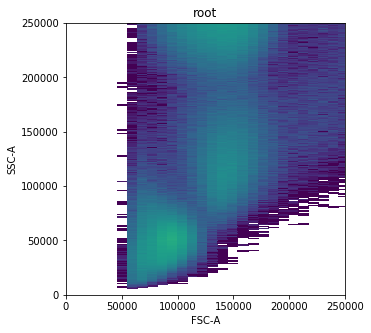

In [21]:
sep6.plotting.plot_population('root', 'FSC-A', 'SSC-A')

In [62]:
root = sep6.get_population_df('root')

In [63]:
sample = root[['FSC-A', 'SSC-A']].sample(frac=0.2)

In [51]:
def plot(data, x, y):
    data = data.copy()
    data = data[(data[x] < data[x].quantile(0.99)) & (data[y] < data[y].quantile(0.99))]
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    fig.show()

In [52]:
sample['FSC-A'].quantile(.99)

262143.0

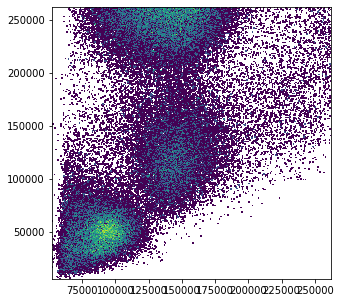

In [53]:
plot(sample, 'FSC-A', 'SSC-A')

In [64]:
data = sample.copy()
x, y = 'FSC-A', 'SSC-A'
data = data[(data[x] < data[x].quantile(0.99)) & (data[y] < data[y].quantile(0.99))]

In [69]:
data.shape

(103178, 2)

In [84]:
knn_model = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)
clusterer = DBSCAN(eps=10000,
               min_samples=1000,
               algorithm='ball_tree',
               n_jobs=-1)

In [85]:
clusterer.fit(data[['FSC-A', 'SSC-A']])

DBSCAN(algorithm='ball_tree', eps=10000, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=1000, n_jobs=-1, p=None)

In [86]:
set(clusterer.labels_)

{-1, 0, 1, 2}

In [87]:
data['labels'] = clusterer.labels_

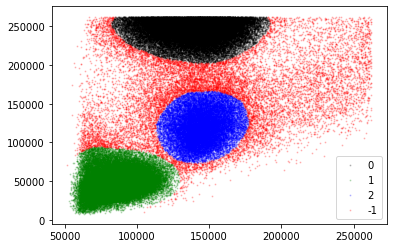

In [88]:
fig, ax = plt.subplots()
colours = cycle(['black', 'green', 'blue', 'red', 'magenta', 'cyan'])
for x, c in zip(data.labels.unique(), colours):
    d = data[data.labels == x]
    ax.scatter(d['FSC-A'], d['SSC-A'], c=c, alpha=0.2, label=x, s=1)
ax.legend()
fig.show()